In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


In [3]:
cat_exp = pd.read_csv('../../src/pnw_explosion_2023_2025.csv')

In [4]:
cat_exp

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-06-18T17:03:42.500Z,43.261833,-123.554333,-0.47,0.65,md,6,92.0,0.14880,0.20,uw,uw62122302,2025-06-18T19:25:25.850Z,"7 km WNW of Melrose, Oregon",explosion,0.65,31.61,0.198924,5,reviewed,uw,uw
1,2025-06-17T19:30:03.810Z,47.113667,-123.102000,-0.23,1.36,ml,13,112.0,0.06747,0.26,uw,uw62129981,2025-06-18T22:28:02.320Z,"11 km S of Shelton, Washington",explosion,0.51,31.61,0.149711,7,reviewed,uw,uw
2,2025-06-17T17:26:00.490Z,49.457167,-120.531000,-0.51,1.96,ml,9,248.0,0.60690,0.41,uw,uw62129891,2025-06-17T18:48:17.230Z,"1 km W of Princeton, Canada",explosion,1.76,31.61,0.089090,8,reviewed,uw,uw
3,2025-06-17T17:20:48.310Z,44.581167,-116.635167,-1.50,1.32,mh,3,141.0,0.54990,0.09,uw,uw62129886,2025-06-17T18:21:47.580Z,"3 km ENE of Cambridge, Idaho",explosion,0.71,31.61,NaN,0,reviewed,uw,uw
4,2025-06-16T22:10:25.770Z,46.888667,-123.767000,-0.23,1.13,ml,11,151.0,0.08369,0.07,uw,uw62129511,2025-06-16T23:54:26.460Z,"7 km S of Cosmopolis, Washington",explosion,0.43,31.61,0.187089,9,reviewed,uw,uw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,2023-01-04T22:38:55.520Z,47.892000,-122.710000,-0.03,1.66,ml,18,50.0,0.09584,0.30,uw,uw61901426,2024-07-15T19:12:02.530Z,"4 km SSW of Port Ludlow, Washington",explosion,0.51,31.61,0.113042,8,reviewed,uw,uw
1659,2023-01-04T00:00:04.550Z,48.509667,-123.499667,-0.24,0.92,ml,4,156.0,0.14380,0.26,uw,uw61901346,2023-01-05T20:25:30.460Z,"6 km NNW of Six Mile, Canada",explosion,1.30,31.61,0.088836,4,reviewed,uw,uw
1660,2023-01-03T21:27:02.710Z,43.604667,-123.063667,-0.53,1.37,ml,8,149.0,0.08158,0.06,uw,uw61901331,2023-01-03T22:10:43.930Z,"17 km E of Yoncalla, Oregon",explosion,0.50,31.61,0.065416,7,reviewed,uw,uw
1661,2023-01-03T20:41:01.760Z,47.006500,-122.201833,-0.54,1.47,ml,16,246.0,0.02069,0.20,uw,uw61901326,2023-01-03T22:05:37.620Z,"2 km NE of Kapowsin, Washington",explosion,0.98,31.61,0.057117,9,reviewed,uw,uw


In [7]:
event_ids = cat_exp.index.values

## Loading the trained model

In [6]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = "cuda"



model_quakexnet_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_esec_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)
model_quakexnet_2d.to(device)
model_quakexnet_2d.eval()


model = model_quakexnet_2d
model.to('cuda')

SeismicCNN_2d(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.9, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Computing the predictions

In [21]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")
model2 = sbm.SeismicCNN.from_pretrained("base")

In [30]:
# defining an empty dictionary to add probabilities data
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f'../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*H*')
    
    # Extract unique station codes
    station_codes = set()
    for f in file_list:
        fname = Path(f).name
        match = re.match(r"[A-Z0-9]+\.(\w+)", fname)
        if match:
            station_codes.add(match.group(1))

    stn_list = sorted(station_codes)
    
    for stn in stn_list:
        chn_list = glob(f'../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{stn}*')

        # Continue only if exactly 3 components are found
        if len(chn_list) == 3:
            try:
                st = obspy.Stream()
                for chn in chn_list:
                    st += obspy.read(chn)
                
                # Optional: sort channels to ensure consistent order
                st.sort(['channel'])
                
                # Predict probabilities using model
                probs_windows = np.array(model2.annotate(st))
                
                # Store in dict
                probs_global[(event_id, stn)] = probs_windows

            except Exception as e:
                print(f"Error with event {event_id}, station {stn}: {e}")


100%|██████████| 1663/1663 [33:49<00:00,  1.22s/it] 


In [31]:
def process_probabilities(probs_dict, threshold=0.5):
    rows = []
    for (event_id, station), prob_array in probs_dict.items():
        
        prob_eq = prob_array[0].max()
        prob_px = prob_array[1].max()
        prob_noise = prob_array[2].max()
        prob_su = prob_array[3].max()

        max_prob = max(prob_eq, prob_px, prob_su)
        if max_prob > threshold:
            if max_prob == prob_eq:
                label = 'eq'
            elif max_prob == prob_px:
                label = 'px'
            else:
                label = 'surface'
        else:
            label = 'noise'

        rows.append({
            'event_id': event_id,
            'station': station,
            'prob_eq': prob_eq,
            'prob_px': prob_px,
            'prob_noise': prob_noise,
            'prob_surface': prob_su,
            'max_prob': max_prob,
            'assigned_label': label
        })

    return pd.DataFrame(rows)


In [32]:
# Example usage:
labels_df = process_probabilities(probs_global)
labels_df.head()
print(len(labels_df))

11125


<Axes: >

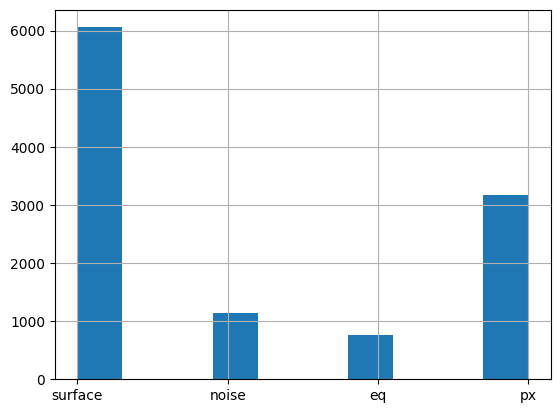

In [33]:
labels_df['assigned_label'].hist()

In [34]:
labels_df.to_csv('../seisbench_output/pnw_new_explosion_output_labels_from_retrained_model.csv')

In [36]:
labels_df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label
0,0,ALSE,0.140935,0.159191,0.900323,0.942733,0.942733,surface
1,0,APLGT,0.141721,0.002225,0.999998,0.004929,0.141721,noise
2,0,BABR,0.005859,0.040005,0.999596,0.000623,0.040005,noise
3,0,BEER,0.691528,0.143184,0.994956,0.478800,0.691528,eq
4,0,BUCK,0.000649,0.082048,0.999990,0.497122,0.497122,noise
...,...,...,...,...,...,...,...,...
11120,1444,COWS,0.554897,0.483584,0.997621,0.238631,0.554897,eq
11121,1444,FMW,0.247488,0.779325,0.774267,0.999721,0.999721,surface
11122,1444,RER,0.132664,0.845789,0.999380,0.946960,0.946960,surface
11123,1444,TOLT,0.004140,0.002242,0.999084,0.889451,0.889451,surface


In [38]:
def plot_trace(tr):
    # Assuming `tr` is your ObsPy Trace object
    data = tr[0].data  # Amplitude values
    npts = tr[0].stats.npts  # Number of samples
    sampling_rate = tr[0].stats.sampling_rate  # Samples per second

    # Create time axis in seconds
    time = np.linspace(0, npts / sampling_rate, npts)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr[0].stats.station}.{tr[0].stats.channel} | {tr[0].stats.starttime}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    
snr = []
for i in tqdm(range(len(labels_df))):
    try:
        label = labels_df['assigned_label'].values[i]
        event_id = labels_df['event_id'].values[i]
        station = labels_df['station'].values[i]
        files = glob(f'../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{station}*HN*')
        tr = obspy.read(files[0])
        tr.resample(50)
        tr.detrend('linear')
        tr.taper(0.05)
        tr.filter('bandpass', freqmin = 1, freqmax = 20)

        #plot_trace(tr)
        #print(label)
        # snr - signal to noise ratio
        d = tr[0].data

        #snr = np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2)))
        #print(snr)

        
        snr.append(np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2))))
    except:
        snr.append(0)
    
labels_df['snr_n'] = snr

100%|██████████| 11125/11125 [01:00<00:00, 184.03it/s]


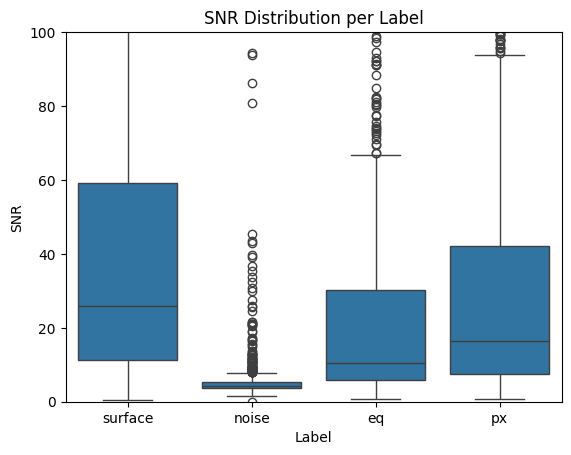

In [42]:
sns.boxplot(data=labels_df, x="assigned_label", y="snr_n")
plt.title("SNR Distribution per Label")
plt.ylim(0,100)
plt.ylabel("SNR")
plt.xlabel("Label")
plt.show()


/tmp/ipykernel_2753492/3073214077.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered, x='assigned_label', palette='pastel', order=filtered['assigned_label'].value_counts().index)


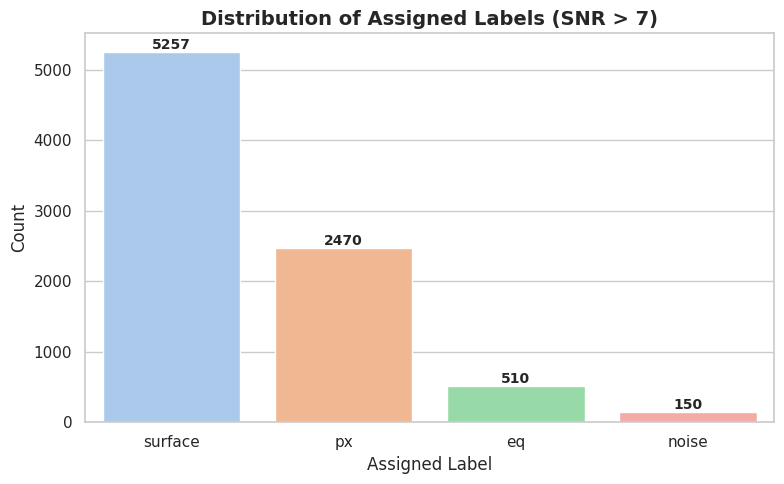

In [43]:
# Set style
sns.set(style="whitegrid")

# Filter and plot
filtered = labels_df[labels_df['snr_n'] > 7]
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered, x='assigned_label', palette='pastel', order=filtered['assigned_label'].value_counts().index)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Assigned Labels (SNR > 7)", fontsize=14, weight='bold')
plt.xlabel("Assigned Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [44]:
good_df  = labels_df[labels_df['snr_n'] > 7]
mean_probs = good_df.groupby('event_id')[['prob_eq', 'prob_px', 'prob_surface']].mean()

# Step 2: Identify the label with the highest mean probability (excluding noise)
mean_probs['event_label'] = mean_probs.idxmax(axis=1).str.replace('prob_', '')

# Optional: merge back into original DataFrame if needed
good_df = good_df.merge(mean_probs['event_label'], on='event_id', how='left')

/tmp/ipykernel_2753492/1556354953.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=mean_probs, x='event_label', palette='Set2')


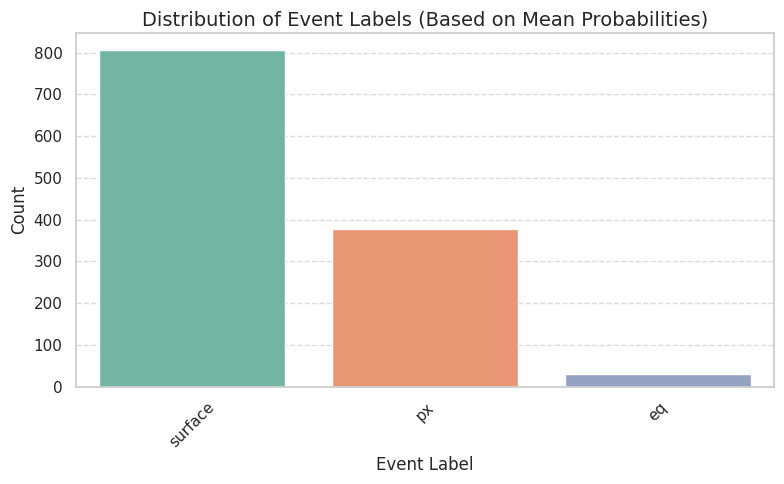

In [45]:
plt.figure(figsize=(8, 5))
sns.countplot(data=mean_probs, x='event_label', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [49]:
def plot_event_waveforms(event_id, labels_df, savepath = '../seisbench_output/pnw_new_classification_figures/earthquake/'):
    # Filter rows for this event
    subset = labels_df[labels_df['event_id'] == event_id]

    if subset.empty:
        print(f"No data found for event {event_id}")
        return
    
    # Get event-level label from the first row
    event_label = subset['event_label'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 1.8 * len(subset)))
    
    for idx, row in subset.iterrows():
        station = row['station']
        
        # Find the vertical-component HZ file
        files = glob(f'../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{station}*HZ*')
        if not files:
            print(f"No HZ component found for {station} in event {event_id}")
            continue
        
        try:
            tr = obspy.read(files[0])[0]
            tr.resample(50)
            tr.detrend('linear')
            tr.taper(0.05)
            tr.filter('bandpass', freqmin=1, freqmax=20)
            data = tr.data
            times = np.arange(len(data)) / tr.stats.sampling_rate

            # Offset the waveform vertically
            offset = idx
            ax.plot(times, data / np.max(np.abs(data)) + offset, lw=0.8, color='steelblue')

            # Format the label with probabilities
            prob_text = f"{station} | eq:{row['prob_eq']:.2f} px:{row['prob_px']:.2f} su:{row['prob_surface']:.2f}"
            ax.text(times[-1] + 2, offset, prob_text, va='center', fontsize=8)

        except Exception as e:
            print(f"Error loading {station} for event {event_id}: {e}")
            continue
    
    ax.set_title(f"Event {event_id} | Label: {event_label.upper()}", fontsize=14, weight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])  # Remove numerical ticks; we use text annotations
    ax.set_ylabel("Stations (vertical offset)")
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Ensure save directory exists
    os.makedirs(savepath, exist_ok=True)
    # Now save
    plt.savefig(os.path.join(savepath, f'{event_id}_from_retrained.png'))
    
    plt.close()

In [50]:
eq_df = mean_probs[mean_probs['event_label'] == 'eq']
px_df = mean_probs[mean_probs['event_label'] == 'px']
su_df = mean_probs[mean_probs['event_label'] == 'surface']

In [51]:
event_ids = eq_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/pnw_new_classification_figures/earthquake/')

    
event_ids = px_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/pnw_new_classification_figures/explosion/')

    
event_ids = su_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/pnw_new_classification_figures/surface/')

## Selecting near field explosions for retraining

### Ok it seems like near field explosion events are getting confused with surface events. We are going to select all the explosions that were labelled as surface events or earthquakes and retrain the model by including these additional explosion events, we will held out a test dataset for the purpose of further testing. 

In [55]:
retrain_df = good_df[good_df['assigned_label'] != 'px']

In [69]:
retrain_ids = np.unique(retrain_df['event_id'])[0:500]
final_retrain_df = retrain_df[retrain_df['event_id'].isin(retrain_ids)]
final_retest_df = retrain_df[~retrain_df['event_id'].isin(retrain_ids)]

In [70]:
final_retest_df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label
3634,613,AGNW,0.007429,0.145115,0.625048,0.999631,0.999631,surface,65.960369,surface
3636,613,H2O,0.025686,0.707756,0.825063,0.999868,0.999868,surface,60.741691,surface
3637,613,PRO,0.029811,0.374436,0.992602,0.999868,0.999868,surface,52.151577,surface
3638,613,SNI2,0.042300,0.956482,0.611664,0.999122,0.999122,surface,51.560611,surface
3639,613,YPT,0.005421,0.855344,0.999999,0.998845,0.998845,surface,76.740406,surface
...,...,...,...,...,...,...,...,...,...,...
8382,1442,VDEB,0.029686,0.929208,0.995216,0.999971,0.999971,surface,56.570425,surface
8383,1444,COWS,0.554897,0.483584,0.997621,0.238631,0.554897,eq,7.470058,surface
8384,1444,FMW,0.247488,0.779325,0.774267,0.999721,0.999721,surface,48.308821,surface
8385,1444,RER,0.132664,0.845789,0.999380,0.946960,0.946960,surface,24.590500,surface


In [72]:
final_retrain_df.to_csv('')

5917